In [1]:
import pandas as pd

df = pd.read_csv('laptop_price.csv', encoding='latin-1')
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [14]:
df.drop_duplicates(keep='first', inplace=True)
brand_counts = df['Company'].value_counts()
small_brands = brand_counts[brand_counts < 10].index
df['Company'] = df['Company'].apply(lambda x: "Others" if x in small_brands else x)

df['OpSys'] = df['OpSys'].replace({'Windows 10 S': 'Windows 10', 'Mac OS X': 'macOS'})
df['OpSys'] = df['OpSys'].replace(['Chrome OS', 'Android'], 'OtherSys')
df['Memory_Type'] = df['Memory'].str.extract(r'(SSD|HDD|Flash Storage)', expand=False)
import re
def convert_to_gb(value):
    unit_map = {'TB': 1024, 'GB': 1}
    match = re.search(r'(\d+)(TB|GB)', value, re.IGNORECASE)
    if match:
        num, unit = match.groups()
        return float(num) * unit_map[unit.upper()]
    return None

def trim_processor(value):
    if value.startswith('Intel'):
        return ' '.join(value.split(' ', 3)[:3])
    else:
        return ' '.join(value.split(' ', 2)[:2])
df[['Processor', 'Clock']] = df['Cpu'].apply(lambda x: pd.Series(str(x).rsplit(' ', 1)))
df['Processor'] = df['Processor'].apply(trim_processor)
cpu_counts = df['Processor'].value_counts()
rare_cpu = cpu_counts[cpu_counts < 10].index
df['Processor'] = df['Processor'].apply(lambda x: "Others" if x in rare_cpu else x)
df['Clock'] = df['Clock'].apply(lambda x: float(str(x).strip("GHz")))

df['Memory_size_GB'] = df['Memory'].apply(convert_to_gb)
df['Ram'] = df["Ram"].apply(lambda x: int(str(x).strip("GB")))
df['Weight'] = df["Weight"].apply(lambda x: float(str(x).strip("kg")))

df['Gpu_Brand'] = df['Gpu'].str.split(n=1, expand=True)[0]

df['Screen_Width'] = df['ScreenResolution'].str.rsplit(' ', n=1).str[-1].str.split('x').str[0]
df = df.drop(['laptop_ID', 'Product', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu'], axis=1)
df

,Company,TypeName,Inches,Ram,OpSys,Weight,Price_euros,Memory_Type,Processor,Clock,Memory_size_GB,Gpu_Brand,Screen_Width
0,Apple,Ultrabook,13.3,8,macOS,1.37,1339.69,SSD,Intel Core i5,2.3,128.0,Intel,2560
1,Apple,Ultrabook,13.3,8,macOS,1.34,898.94,Flash Storage,Intel Core i5,1.8,128.0,Intel,1440
2,HP,Notebook,15.6,8,No OS,1.86,575.00,SSD,Intel Core i5,2.5,256.0,Intel,1920
3,Apple,Ultrabook,15.4,16,macOS,1.83,2537.45,SSD,Intel Core i7,2.7,512.0,AMD,2880
4,Apple,Ultrabook,13.3,8,macOS,1.37,1803.60,SSD,Intel Core i5,3.1,256.0,Intel,2560
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,2 in 1 Convertible,14.0,4,Windows 10,1.80,638.00,SSD,Intel Core i7,2.5,128.0,Intel,1920
1299,Lenovo,2 in 1 Convertible,13.3,16,Windows 10,1.30,1499.00,SSD,Intel Core i7,2.5,512.0,Intel,3200
1300,Lenovo,Notebook,14.0,2,Windows 10,1.50,229.00,Flash Storage,Intel Celeron Dual,1.6,64.0,Intel,1366
1301,HP,Notebook,15.6,6,Windows 10,2.19,764.00,HDD,Intel Core i7,2.5,1024.0,AMD,1366


Pojawiają się wartości odstające, ale są to wartości realne. Nie jest więc uzasadnione pozbywanie się ich.

**Czyszczenie danych**

In [149]:
any_nan = df.isnull().values.any()
any_nan

True

In [150]:
def remove_outliers(df, columns):
    indices_to_remove = set()

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_indices = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        indices_to_remove.update(outliers_indices)

    df_cleaned = df.drop(indices_to_remove)

    return df_cleaned
df = remove_outliers(df, ['Price_euros', "Inches"])
df

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Memory_Type,Memory_size_GB,MedianPrice,MedianRamVal,MedianInches
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,SSD,128.0,1339.69,8.0,13.3
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,Flash Storage,128.0,1339.69,8.0,13.3
2,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,SSD,512.0,1339.69,8.0,13.3
3,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,SSD,256.0,1339.69,8.0,13.3
4,7,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.2GHz,16,256GB Flash Storage,Intel Iris Pro Graphics,Mac OS X,2.04kg,2139.97,Flash Storage,256.0,1339.69,8.0,13.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,918,HP,Elitebook 820,Netbook,12.5,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8,512GB SSD,Intel HD Graphics 620,Windows 10,1.26kg,1483.00,SSD,512.0,966.50,8.0,11.6
1281,949,HP,EliteBook 820,Netbook,12.5,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8,256GB SSD,Intel HD Graphics 520,Windows 10,1.26kg,1669.00,SSD,256.0,966.50,8.0,11.6
1282,1004,HP,EliteBook Folio,Netbook,12.5,Full HD 1920x1080,Intel Core M 6Y75 1.2GHz,8,512GB SSD,Intel HD Graphics 515,Windows 10,0.97kg,1908.00,SSD,512.0,966.50,8.0,11.6
1283,1109,HP,Elitebook 820,Netbook,12.5,1366x768,Intel Core i5 6200U 2.3GHz,4,128GB SSD,Intel HD Graphics 520,Windows 7,2.4kg,1599.00,SSD,128.0,966.50,8.0,11.6


**Hot One Encoding**

In [17]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
df_cleaned = df.copy()
columns_to_encode=['Company','TypeName', 'OpSys', 'Memory_Type', 'Gpu_Brand', "Processor"]
encoded_data = encoder.fit_transform(df_cleaned[columns_to_encode])
encoded_df = pd.DataFrame(encoded_data.toarray(), index=df_cleaned.index, columns=encoder.get_feature_names_out(columns_to_encode))

df_coded = df_cleaned.drop(columns_to_encode, axis=1).join(encoded_df)
df_coded.head()


,Inches,Ram,Weight,Price_euros,Clock,Memory_size_GB,Screen_Width,Company_Acer,Company_Apple,Company_Asus,...,Gpu_Brand_Nvidia,Processor_AMD A6-Series,Processor_AMD A9-Series,Processor_Intel Celeron Dual,Processor_Intel Core M,Processor_Intel Core i3,Processor_Intel Core i5,Processor_Intel Core i7,Processor_Intel Pentium Quad,Processor_Others
0,13.3,8,1.37,1339.69,2.3,128.0,2560,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,13.3,8,1.34,898.94,1.8,128.0,1440,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,15.6,8,1.86,575.00,2.5,256.0,1920,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,15.4,16,1.83,2537.45,2.7,512.0,2880,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,13.3,8,1.37,1803.60,3.1,256.0,2560,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


**Normalizacja zmiennych**

In [153]:
mean_values = df_coded.mean()
std_values = df_coded.std()

print("Średnie wartości dla każdej kolumny:\n", mean_values)
print("\nOdchylenia standardowe dla każdej kolumny:\n", std_values)

Średnie wartości dla każdej kolumny:
 Inches                           15.091417
Ram                               8.176518
Weight                            2.032842
Price_euros                    1088.451943
Memory_size_GB                  447.731174
                                  ...     
Screen_Resolution_2560x1600       0.004858
Screen_Resolution_2736x1824       0.000810
Screen_Resolution_2880x1800       0.002429
Screen_Resolution_3200x1800       0.021862
Screen_Resolution_3840x2160       0.025911
Length: 171, dtype: float64

Odchylenia standardowe dla każdej kolumny:
 Inches                           1.280792
Ram                              4.271719
Weight                           0.615106
Price_euros                    591.728043
Memory_size_GB                 364.751916
                                  ...    
Screen_Resolution_2560x1600      0.069560
Screen_Resolution_2736x1824      0.028456
Screen_Resolution_2880x1800      0.049246
Screen_Resolution_3200x1800      0.146

In [154]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns_to_scale = ['Inches', 'Ram', 'Weight', 'Price_euros', 'Memory_size_GB']
df_scaled = scaler.fit_transform(df_coded[columns_to_scale])
df_scaled = pd.DataFrame(df_scaled, columns=columns_to_scale)
df_coded.drop(columns=columns_to_scale, inplace=True)
df_coded = df_coded.join(df_scaled)
mean_values = df_coded.mean()
std_values = df_coded.std()

print("Średnie wartości dla każdej kolumny:\n", mean_values)
print("\nOdchylenia standardowe dla każdej kolumny:\n", std_values)

Średnie wartości dla każdej kolumny:
 Company_Acer      0.076113
Company_Apple     0.015385
Company_Asus      0.119838
Company_Chuwi     0.002429
Company_Dell      0.229150
                    ...   
Inches            0.006377
Ram              -0.012679
Weight           -0.005605
Price_euros      -0.004989
Memory_size_GB    0.004636
Length: 171, dtype: float64

Odchylenia standardowe dla każdej kolumny:
 Company_Acer      0.265287
Company_Apple     0.123127
Company_Asus      0.324904
Company_Chuwi     0.049246
Company_Dell      0.420456
                    ...   
Inches            0.996381
Ram               0.989747
Weight            0.989920
Price_euros       1.006381
Memory_size_GB    1.004643
Length: 171, dtype: float64


**Regresja wielomianowa**

In [170]:
from sklearn.model_selection import train_test_split

df_coded = df_coded.dropna()
X = df_coded.drop('Price_euros', axis=1)
y = df_coded['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [171]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
print(f'Współczynniki: {linear_model.coef_}')

Współczynniki: [-3.82209200e+01  4.27354274e+01  1.35278533e+02  2.92768126e-02
 -1.14388517e+11 -1.26440391e+11 -1.14388517e+11  5.42755291e+11
 -1.14388517e+11 -1.14388517e+11 -6.12084559e+11 -1.14388516e+11
  5.87215609e+10 -3.96336751e+11 -1.14388517e+11 -1.14388516e+11
 -1.14388517e+11  1.82903861e+11 -1.14388516e+11 -1.14388516e+11
 -1.14388516e+11 -1.14388517e+11 -1.14388516e+11  1.37152767e+12
  1.37152767e+12  1.37152767e+12  1.37152767e+12  1.37152767e+12
  1.37152767e+12 -4.67353663e+10 -4.67353662e+10 -4.67353663e+10
 -4.67353662e+10 -4.67353662e+10 -4.67353663e+10 -4.67353662e+10
 -7.93918102e+09 -4.67353663e+10 -4.67353661e+10 -4.67353664e+10
 -4.67353663e+10 -4.67353661e+10 -4.67353664e+10 -4.67353662e+10
 -4.86485316e+09 -6.06398669e+11 -4.67353663e+10 -4.67353663e+10
 -4.67353663e+10 -4.67353664e+10 -4.67353664e+10 -4.67353662e+10
  2.36929939e+08 -4.67353661e+10 -4.67353653e+10 -4.67353656e+10
 -4.67353663e+10  5.64592602e+11 -7.03879175e+11 -4.67353666e+10
 -4.673536

In [172]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
print(f'Współczynniki: {lasso_model.coef_}')


Współczynniki: [-3.93732251e+01  5.44538352e+01  1.03335378e+02  3.71726173e-02
 -1.20920973e+02  6.95680923e+01 -5.03082866e+01 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  5.63785452e+01
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.18755800e+02
 -2.02374550e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.09300279e+02 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -2.26210534e+02  1.11394328e+02
  4.55109159e+02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.000000

In [173]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
print(f'Współczynniki: {ridge_model.coef_}')


Współczynniki: [-4.11223895e+01  4.71412337e+01  1.32135392e+02  2.95646943e-02
 -1.27209907e+02  6.34481518e+01 -4.47787067e+01 -2.06762576e+02
 -2.48848329e+01 -1.27829910e+02  8.01570409e+01  4.44871881e+01
  0.00000000e+00  0.00000000e+00 -1.43721352e+01  1.63622214e+02
 -2.56304798e+02  3.93952520e+01  2.75416164e+02  1.04410551e+02
  1.30660979e+02 -1.65992340e+02  6.65376668e+01 -3.50871897e+01
 -1.55239691e+02  9.38730133e+00 -2.35891601e+02  8.91794641e+01
  3.27651717e+02 -1.09142404e+02 -3.83807039e+01 -1.19870032e+02
 -4.16967796e+01 -6.56078275e+01 -1.48727928e+02 -3.80630814e+01
  0.00000000e+00 -1.78676084e+02  4.54562358e+01 -2.10898603e+02
 -9.99869143e+01 -2.54972734e+01 -1.57165676e+02 -7.92441780e+01
  0.00000000e+00 -9.91256359e+01 -7.86390535e+01 -7.06724084e+01
 -7.79953005e+01 -8.67562774e+01 -1.32754702e+02 -6.86830284e+01
  0.00000000e+00 -6.18592520e+01  3.40315523e+02  3.10756657e+02
 -7.29655012e+01 -7.72344049e+01 -1.26790359e+02 -1.74677892e+02
 -1.828461

In [174]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=3)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)
print(f'Współczynniki: {poly_model.coef_}')



Współczynniki: [-2.20699527e+05  1.15947940e+04  3.95172579e+03 ...  0.00000000e+00
  0.00000000e+00 -2.46205211e+00]


In [175]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)


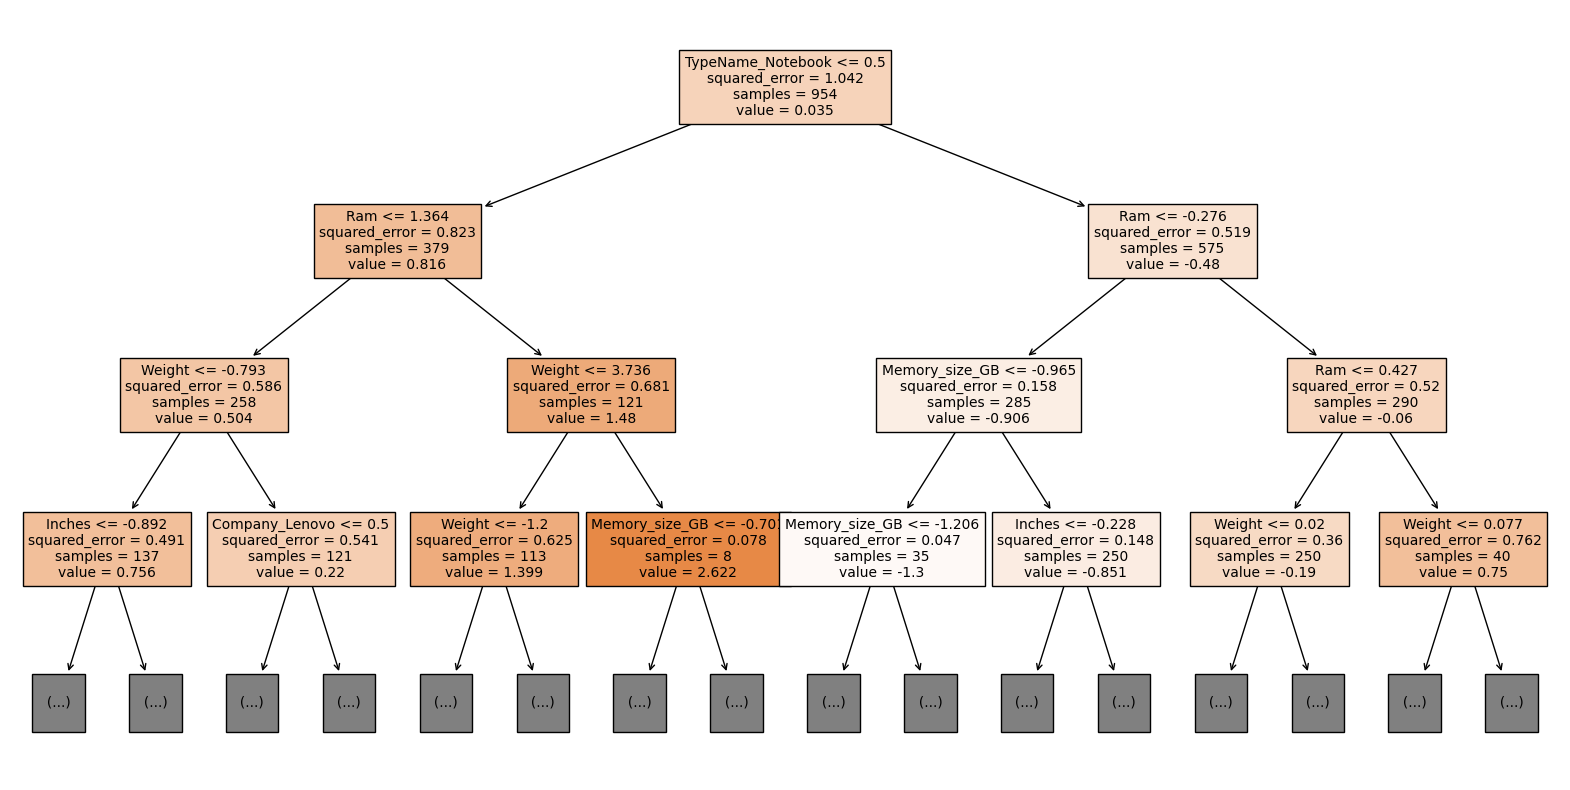

In [161]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(tree_model, filled=True, feature_names=X.columns, max_depth=3, fontsize=10)
plt.show()


In [176]:
model_names = ['Linear', 'Lasso', 'Ridge', 'Polynomial', 'Decision Tree']
predictions = [y_pred_linear, y_pred_lasso, y_pred_ridge, y_pred_poly, y_pred_tree]
results = []

for model_name, pred in zip(model_names, predictions):
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    results.append({"Model": model_name, "MSE": mse, "R2": r2})

results_df = pd.DataFrame(results)

In [177]:
results_df

,Model,MSE,R2
0,Linear,1.100840e+22,-3.472535e+16
1,Lasso,8.961746e+04,7.173070e-01
2,Ridge,8.198587e+04,7.413804e-01
3,Polynomial,8.841362e+11,-2.788955e+06
4,Decision Tree,1.125415e+05,6.449945e-01
